In [0]:
# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1
import warnings
warnings.filterwarnings('ignore')

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

TensorFlow 2.x selected.


'2.0.0-rc0'

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import os
import pathlib
import pandas as pd
from PIL import Image
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

## Define Constants

In [0]:
IMAGE_WIDTH = 170
IMAGE_HEIGHT = 170
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32

## Load and preprocess data

In [6]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [19]:
import pathlib
data_root = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/')
data_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/vnd/')
data_cleaned_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/')
data_train_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/train')
data_val_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/validation')
print(data_root)
print(data_train_path)
print(data_val_path)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/train
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/validation


### Utils functions

In [0]:
# This function will get all image paths and file size
def get_file_size_from_path(path):
  labels = [x.name for x in path.glob('*') if x.is_dir() and x.name.endswith('0')]
  label_names = {key:value for value, key in enumerate(sorted(labels))}
  
  all_images = [str(x) for x in path.glob('*/*') if x.parent.name in label_names]

  results = []
  for image in all_images:
    fsize = os.path.getsize(image)
    results.append([image, fsize])
  
  return results

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(4, 3, figsize=(12,12))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

### Get all labels

In [9]:
labels = [x.name for x in data_source.glob('*') if x.is_dir() and x.name.endswith('0')]
label_names = {key:value for value, key in enumerate(sorted(labels))}
label_names

{'10000': 0, '20000': 1, '50000': 2}

### Get file size from data source

In [10]:
all_images = [str(x) for x in data_source.glob('*/*') if x.parent.name in label_names]

all_images_with_size = []
for image in all_images:
  fsize = os.path.getsize(image)
  im = Image.open(image)
  all_images_with_size.append([image, im.width, im.height, fsize])

all_images_with_size[:10]

[['/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/vnd/20000/20190827_142658.jpg',
  5312,
  2988,
  4089452],
 ['/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/vnd/20000/20190827_142735.jpg',
  5312,
  2988,
  4865095],
 ['/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/vnd/20000/20190827_142703.jpg',
  5312,
  2988,
  3527087],
 ['/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/vnd/20000/20190827_142657.jpg',
  5312,
  2988,
  4138560],
 ['/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/vnd/20000/20190827_142526.jpg',
  5312,
  2988,
  3974578],
 ['/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/vnd/20000/20190827_142518.jpg',
  5312,
  2988,
  4716104],
 ['/content/gdrive/My Drive/

### Get large images

#### Create a DataFrame for all images

In [11]:
df_source_images = pd.DataFrame(all_images_with_size, columns=['filename', 'width', 'height', 'filesize'])
df_source_images.info()
df_source_images.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 4 columns):
filename    590 non-null object
width       590 non-null int64
height      590 non-null int64
filesize    590 non-null int64
dtypes: int64(3), object(1)
memory usage: 18.5+ KB


,filename,width,height,filesize
504,/content/gdrive/My Drive/PROJECTS/CoderSchool_...,640,480,66400
223,/content/gdrive/My Drive/PROJECTS/CoderSchool_...,5312,2988,5148645
315,/content/gdrive/My Drive/PROJECTS/CoderSchool_...,5312,2988,3416159
182,/content/gdrive/My Drive/PROJECTS/CoderSchool_...,5312,2988,2315895
339,/content/gdrive/My Drive/PROJECTS/CoderSchool_...,5312,2988,4620944


#### Visualize all images by file size

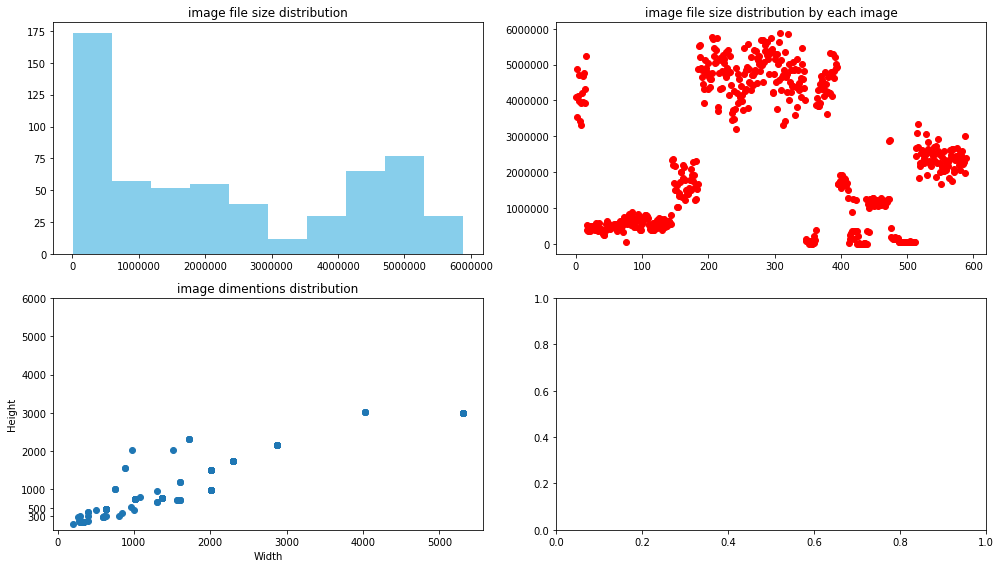

In [12]:
fig, ax = plt.subplots(2, 2 , figsize=[14, 8])

ax[0,0].hist(df_source_images.filesize, color="skyblue")
ax[0,0].set_title('image file size distribution')

ax[0,1].plot(df_source_images.filesize, 'ro')
ax[0,1].set_title('image file size distribution by each image')

ax[1,0].scatter(df_source_images.width, df_source_images.height)
ax[1,0].set_title('image dimentions distribution')
ax[1,0].set_xlabel('Width')
ax[1,0].set_ylabel('Height')
ax[1,0].set_yticks([300, 500, 1000, 2000, 3000, 4000, 5000, 6000])

plt.tight_layout()
plt.show()

Notice that there are files with large size (over 1MB), we will need to reduce these files' size.

### Resize all large images

In [21]:
for image_path in df_source_images.filename.tolist():
    
  image = Image.open(image_path)

  # check if image is PNG
  if len(image.split()) > 3:
    #convert PNG to JPEG
    image = image.convert('RGB')
  
  # check destination folders
  if not data_cleaned_source.is_dir():
    # destination train folder is not existed, create one
    os.mkdir(data_cleaned_source)
  
  # get the file name
  image_splits = image_path.rsplit('/', 2)
  dest_folder = pathlib.Path(os.path.join(data_cleaned_source, image_splits[1]))
  
  # if destination folder not existed, then create one
  if not dest_folder.is_dir():
    os.mkdir(dest_folder)
   
  # set destination file name
  dest_filename = pathlib.Path(os.path.join(image_path.rsplit('/', 2)[-2], image_path.rsplit('/', 2)[-1]))
  # set new destination
  dest_filename = pathlib.Path(os.path.join(data_cleaned_source, dest_filename))
  print(dest_filename)
  
  # image resizing process
  if image.width > 500 or image.height > 500:
    # set the new dimensions
    if (image.width > image.height): # landscape image
      new_size = (500, int(500/(image.width/image.height)))
    else: # portrait image
       new_size = tuple(reversed(new_size))
     
    output = image.resize(new_size)
    
    # save all resized file to new destination
    if not dest_filename.is_file():
      output.save(dest_filename)
    
  else: # now working on the rest images
    if not dest_filename.is_file():
      image.save(dest_filename)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142658.jpg
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142735.jpg
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142703.jpg
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142657.jpg
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142526.jpg
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142518.jpg
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142527.jpg
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/mo

In [14]:
all_preprocessed_images = [str(x) for x in data_root.glob('*/*') if x.parent.name in label_names]

all_images_with_size = []
for image in all_preprocessed_images:
  fsize = os.path.getsize(image)
  im = Image.open(image)
  all_images_with_size.append([image, im.width, im.height, fsize])

all_images_with_size[:10]

[]

### Plot some preprocessed images

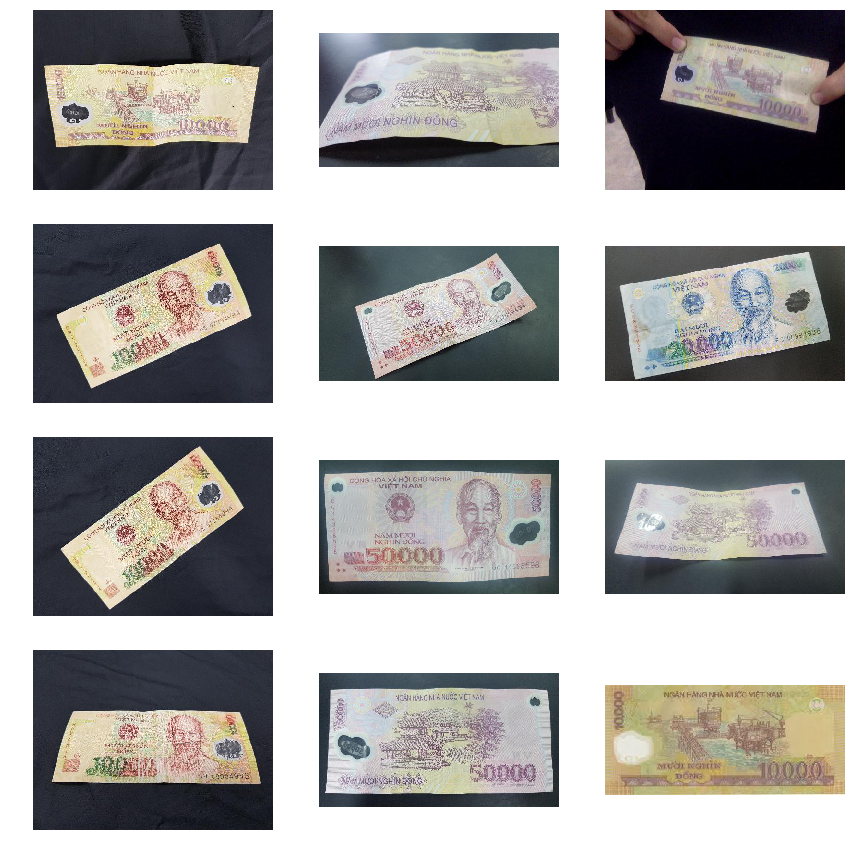

In [15]:


all_preprocessed_images = [str(x) for x in data_train_path.glob('*/*') if x.parent.name in label_names]

random.shuffle(all_preprocessed_images)

image_list = []
for image_path in all_preprocessed_images[:12]:
  image = Image.open(image_path)
  image_list.append(image)

plotImages(image_list)

### Train - Validation splitting

In [0]:
random.seed(42)

TRAIN_SIZE = 0.8

# check if train folder is existed or not
if not data_train_path.is_dir():
  # destination train folder is not existed, create one
  os.mkdir(data_train_path)

# check if validation folder is existed or not
if not data_val_path.is_dir():
  # destination train folder is not existed, create one
  os.mkdir(data_val_path)
    
for label in labels:
  label_path = pathlib.Path(os.path.join(data_cleaned_source, label))
  
  label_images = [image for image in label_path.glob('*') if image.is_file()]
  random.shuffle(label_images)
  label_images_total = len(label_images)
  dest_train_path = pathlib.Path(os.path.join(data_train_path, label))
  dest_val_path = pathlib.Path(os.path.join(data_val_path, label))
  
  if not dest_train_path.is_dir():
    # destination folder is not existed, create one
    os.mkdir(dest_train_path)
  
  if not dest_val_path.is_dir():
    # destination folder is not existed, create one
    os.mkdir(dest_val_path)
  
  train_total = int(label_images_total*TRAIN_SIZE)

  for index in range(0, train_total):
    shutil.copy(label_images[index], dest_train_path)
  
  for index in range(train_total, label_images_total):
    shutil.copy(label_images[index], dest_val_path)
  
#   print(label_path)
#   print('total:', label_images_total)
#   print(label_images[train_total])
#   print('train:', i)
#   print('val:', j)

## Create model

In [8]:
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'validation')

train_10k_dir = os.path.join(train_dir, '10000')
train_20k_dir = os.path.join(train_dir, '20000')
train_50k_dir = os.path.join(train_dir, '50000')
validation_10k_dir = os.path.join(validation_dir, '10000')
validation_20k_dir = os.path.join(validation_dir, '20000')
validation_50k_dir = os.path.join(validation_dir, '50000')

num_10k_train = len(os.listdir(train_10k_dir))
num_20k_train = len(os.listdir(train_20k_dir))
num_50k_train = len(os.listdir(train_50k_dir))

num_10k_validation = len(os.listdir(validation_10k_dir))
num_20k_validation = len(os.listdir(validation_20k_dir))
num_50k_validation = len(os.listdir(validation_50k_dir))

total_train = num_10k_train + num_20k_train + num_50k_train
total_validation = num_10k_validation + num_20k_validation + num_50k_validation

print('total training 10k images:', num_10k_train)
print('total training 20k images:', num_20k_train)
print('total training 50k images:', num_50k_train)

print('total validation 10k images:', num_10k_validation)
print('total validation 20k images:', num_20k_validation)
print('total validation 50k images:', num_50k_validation)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_validation)
print("--")

# Preprocess Train dataset
train_img_datagen = ImageDataGenerator(
                                        rescale=1./255
#                                         rescale=1./255,
#                                         rotation_range=45,
#                                         shear_range=0.1,
#                                         zoom_range=0.2,
#                                         horizontal_flip=True
                                      )

train_generator = train_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=data_train_path,
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

# Preprocess Validation dataset
validation_img_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=data_val_path,
                                                              target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              class_mode='binary')

total training 10k images: 151
total training 20k images: 149
total training 50k images: 195
total validation 10k images: 30
total validation 20k images: 30
total validation 50k images: 30
--
Total training images: 495
Total validation images: 90
--
Found 495 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


## Plot augmented images

In [0]:
index = np.random.randint(0, len(train_generator))
augmented_images = [train_generator[index][0][0] for i in range(15)]
plotImages(augmented_images)

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def create_model():
  
  model = tf.keras.Sequential()

  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='softmax')) 
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#   model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [0]:
model = create_model()
model.summary()

## Train Model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model.h5', verbose=1, save_best_only=True)
]

In [0]:
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validation // BATCH_SIZE,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

## Visualize training results

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [0]:
Save the entire model to a HDF5 file
model.save('static/models/my_model.h5')